In [3]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import os
from cv2 import cv2 as cv
import random 
import argparse
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

Definition der Datensatz Klasse, diese stellt Bilder + Annotationen zum training bereit. Die Bilder werden dabei zur trainingszeit zusammen gesetzt sodass eine Explizite größen angabe erfolgen muss.

In [4]:
class fake_dataset(Dataset):
    def __init__(self, sign_path: str, background_path: str, length: int, 
                 scr: tuple[int, int], img_sice: tuple[int, int], sign_sice: tuple[int, int], transforms = None):
        self.sign_path = sign_path
        self.background_path = background_path
        self.signs = os.listdir(sign_path)
        self.backgrounds = os.listdir(background_path)
        self.length = length
        self.scr = scr
        self.sign_size = sign_sice
        self.transforms = transforms
        self.name2label = {"KeepRight": 1, "MaxSpeed25": 2, "MaxSpeed35": 2, "Merge": 3, "PedestrianCrossing": 4, "Stop": 5, "TrafficLightAhead": 6, "Yield": 7, "YieldAhead": 8}
    def get_rand_img(root, paths) -> np.ndarray:
        path = paths[random.randrange(0, len(paths))]
        img = cv.imread(os.path.join(root, path), cv.IMREAD_UNCHANGED)
        if (img.shape[2] == 3):
            img = img[:,:,[2, 1, 0]]
        elif (img.shape[2] == 4):
            img = img[:,:,[2, 1, 0, 3]]
        else:
            assert False
        return img, path
    def sign_path2label(self, path:str):
        return self.name2label[path.split("_")[0]]
    def __len__(self) -> int:
        return self.length
    def __getitem__(self, idx):
        sign_count = random.randrange(self.scr[0], self.scr[1])
        img, path = fake_dataset.get_rand_img(self.background_path, self.backgrounds)
        boxes = []
        labels = []
        area = []
        for i in range(sign_count):
            sign, path = fake_dataset.get_rand_img(self.sign_path, self.signs)
            size = random.randrange(self.sign_size[0], self.sign_size[1])
            scaling = size / max(sign.shape)
            sign = cv.resize(sign, dsize=(0, 0), fx=scaling, fy=scaling)
            w = sign.shape[0]
            h = sign.shape[1]
            x = random.randrange(0, img.shape[0] - sign.shape[0])
            y = random.randrange(0, img.shape[1] - sign.shape[1])
            alpha = sign[:,:,3]/255
            alpha = np.stack([alpha, alpha, alpha], axis=-1)
            sign = sign[:,:,0:3] * alpha
            img[x:x+w, y:y+h,:] = img[x:x+w, y:y+h,:] * (1-alpha) + sign
            boxes.append(np.array([x, y, x+w, y+h]))
            labels.append(self.sign_path2label(path))
            area.append(w*h)
        target = {"boxes": torch.tensor(np.stack(boxes), dtype=torch.float32), 
                  "labels": torch.tensor(labels, dtype=torch.int64),
                  "image_id": torch.tensor([idx], dtype=torch.int64),
                  "area": torch.tensor(area, dtype=torch.float32),
                  "iscrowd": torch.zeros((sign_count,), dtype=torch.bool),
                  }
        img = Image.fromarray(img)
        # = np.transpose(img, (2, 0, 1))
        #img = torch.tensor(img, dtype=torch.float32) / 255
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

Testing the Dataset

In [5]:
dataset = fake_dataset("blender/out/imgs", "backgrounds", 1, (3, 7), (1280, 720), (100, 500))

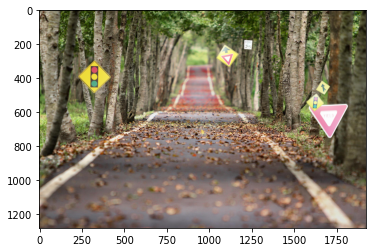

{'boxes': tensor([[ 165.,  981.,  377., 1228.],
        [ 243.,  151.,  543.,  500.],
        [ 483., 1500.,  832., 1906.],
        [ 392., 1593.,  523., 1746.],
        [ 162., 1177.,  249., 1278.],
        [ 459., 1524.,  629., 1722.]]), 'labels': tensor([8, 6, 7, 3, 2, 6]), 'image_id': tensor([0]), 'area': tensor([ 52364., 104700., 141694.,  20043.,   8787.,  33660.]), 'iscrowd': tensor([False, False, False, False, False, False])}


In [6]:
img, target = dataset.__getitem__(0)
plt.figure()
plt.imshow(img)
plt.show()
print(target)

In [44]:
import detection.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.Normalize())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Setting up the Model, Dataset and Dataloaders

In [45]:
import detection.utils as utils
device = torch.device("cuda")
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(num_classes=9)
model.to(device)
dataset_train = fake_dataset("blender/out/imgs", "backgrounds", 1000, (3, 7), (1280, 720), (100, 500), get_transform(True))
dataset_eval = fake_dataset("blender/out/imgs", "backgrounds", 100, (3, 7), (1280, 720), (100, 500), get_transform(False))
train_loader = DataLoader(dataset_train, 4, collate_fn=utils.collate_fn)
eval_loader = DataLoader(dataset_eval, 4, collate_fn=utils.collate_fn)


In [46]:
test_img, test_target = dataset_train.__getitem__(0)
#model([test_img], [test_target])

In [47]:

#@todo Fix Hardcoded params
num_epochs = 16
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

from detection.engine import train_one_epoch, evaluate

for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, eval_loader, device=device)


Epoch: [0]  [  0/250]  eta: 0:05:10  lr: 0.000025  loss: 5.4227 (5.4227)  loss_classifier: 4.5366 (4.5366)  loss_box_reg: 0.1196 (0.1196)  loss_objectness: 0.7006 (0.7006)  loss_rpn_box_reg: 0.0659 (0.0659)  time: 1.2408  data: 0.7777  max mem: 2011
Epoch: [0]  [ 10/250]  eta: 0:04:04  lr: 0.000226  loss: 5.4227 (5.5677)  loss_classifier: 4.4064 (4.2318)  loss_box_reg: 0.0776 (0.0857)  loss_objectness: 0.7006 (0.7000)  loss_rpn_box_reg: 0.1509 (0.5502)  time: 1.0197  data: 0.8099  max mem: 2011
Epoch: [0]  [ 20/250]  eta: 0:03:53  lr: 0.000426  loss: 4.0059 (4.0946)  loss_classifier: 3.0055 (2.8703)  loss_box_reg: 0.0912 (0.1032)  loss_objectness: 0.6987 (0.6988)  loss_rpn_box_reg: 0.1681 (0.4224)  time: 1.0029  data: 0.8179  max mem: 2011
Epoch: [0]  [ 30/250]  eta: 0:03:38  lr: 0.000627  loss: 1.5676 (3.2681)  loss_classifier: 0.6786 (2.1389)  loss_box_reg: 0.0975 (0.1009)  loss_objectness: 0.6929 (0.6947)  loss_rpn_box_reg: 0.1213 (0.3337)  time: 0.9787  data: 0.7955  max mem: 2011


KeyboardInterrupt: 

In [ ]:
torch.save(model,"models/fasterrcnn_mobilenet_v3_large_fpn")